# Exercise 4: Expectation-Maximization

In this assignment you will implement the Expectation-Maximization algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write vectorized code whenever possible.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in the provided `hw4.py` python module only. All the logic you write is imported and used in this jupyter notebook.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports detected in `hw4.py` will earn you the grade of 0, even if you only used them for testing.
6. You are, however, encouraged to use E-M implementation from sklearn to test your code in the notebook. DO NOT import sklearn in `hw4.py`.
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install. Changes of the configuration we provided are at your own risk. Code that cannot run will also earn you the grade of 0.
7. Write your own code. Cheating will not be tolerated. 
8. Submission includes the `hw4.py` file and this notebook. Answers to qualitative questions should be written in markdown cells (with $\LaTeX$ support).
9. You are allowed to include additional functions.
10. Submission: zip containing only the completed jupyter notebook and the python file `hw4.py`. Do not include the data or any directories. Name the file `ID1_ID2.zip` and submit *only one copy* of the assignment.


## In this exercise you will perform the following:

1. Use the sklearn library to fit two gaussians and plot the results
2. Implement E-M algorithm and apply it on a dataset with unknown distribution 

## important notes:
1. You will only be graded for the code in `hw4.py`
2. Each function you write will be tested automatically with python unit tests. you are not allowed to change the input or output formats of the functions.
3. In order to avoid variable type mistakes and make sure your format is correct, several tests were added for you within this notebook. 

In [1]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

In [3]:
from hw4.hw4 import *

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Part 1 - Warmup - fitting gaussians with sklearn (10 points)

## Data preparation

We will create a dataset composed of two gaussians and learn their parameter using sklearn.

(-4, 11)

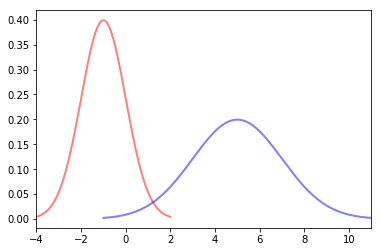

In [248]:
PLOT_WIDTH_IN_SIGMA = 3
mu1 = -1
sigma1 = 1
x1 = np.linspace(mu1 - PLOT_WIDTH_IN_SIGMA * sigma1, mu1 + PLOT_WIDTH_IN_SIGMA * sigma1, 1000)
y1 = norm.pdf(x1, mu1, sigma1)

mu2 = 5
sigma2 = 2
x2 = np.linspace(mu2 - PLOT_WIDTH_IN_SIGMA * sigma2, mu2 + PLOT_WIDTH_IN_SIGMA * sigma2, 1000)
y2 = norm.pdf(x2, mu2, sigma2)

plt.plot(x1, y1, color='red', lw=2, ls='-', alpha=0.5)
plt.plot(x2, y2, color='blue', lw=2, ls='-', alpha=0.5)

plt.xlim(min(mu1 - PLOT_WIDTH_IN_SIGMA * sigma1, mu2 - PLOT_WIDTH_IN_SIGMA * sigma2), max(mu1 + PLOT_WIDTH_IN_SIGMA * sigma1, mu2 + PLOT_WIDTH_IN_SIGMA * sigma2))
plt.show()

Next, we will sample 500 instances from each gaussian

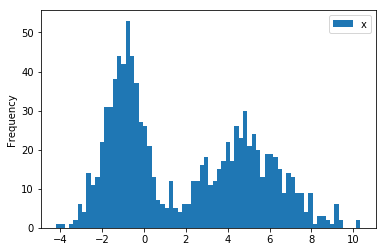

In [249]:
np.random.seed(10)
first_gaussian = norm.rvs(loc=mu1, scale=sigma1, size=500)
second_gaussian = norm.rvs(loc=mu2, scale=sigma2, size=500)
xs = np.concatenate((first_gaussian, second_gaussian))
df = pd.DataFrame(data={'x': xs})
ax = df.plot.hist(bins=70)

Given the sample data we want to run EM in order to find the population distribution. <br>
We first need to decide about the the distribution parameters. <br>
After seeing the sample plot we can assume that the distribution of the population is GMM with 2 gaussians (remember that we won't see the first plot of the real distribution, but only the sample plot) 

In [250]:
from sklearn.mixture import GaussianMixture

# TODO: init a GaussianMixture with 2 components
# TODO: fit your model with the given data and predict the gaussian for each data point 
# hint: use sklearn.mixture.GaussianMixture ducomentation if you need help with find the relevant method

gm = GaussianMixture(n_components=2)

fg = first_gaussian.reshape(-1, 1)
sg = second_gaussian.reshape(-1, 1)

gm.fit(np.concatenate([fg, sg]))

predict1 = gm.predict(fg)
predict2 = gm.predict(sg)

z=np.concatenate([predict1, predict2])
df['z'] = z # z is an array of size 1000 where z[i] is the number of the gaussian the i-th point belongs to (either 0 or 1)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

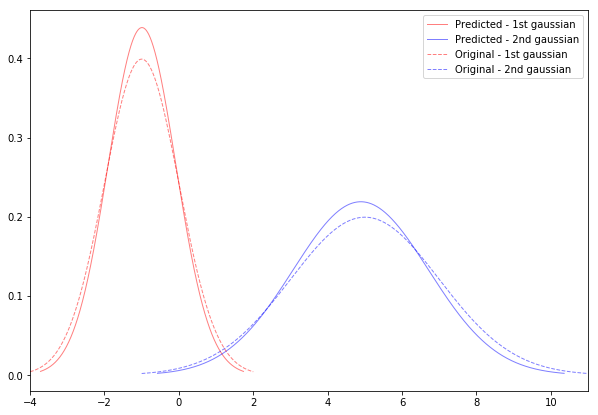

mu_1: -1 ,predicted mu_1: -0.991645233753801
sigma_1: 1, predicted sigma_1: 0.9092561066616276
mu_2: 5 ,predicted mu_2: 4.890644124456295
sigma_2: 2, predicted sigma_2: 1.8218749170651534


In [251]:
plot_pred_vs_actual(df)

As we can see, we almost found the original parameter only with 500 samples from each gaussian

# Part 2 - Implementing EM (90 points)

In this part you will implement the EM algorithm

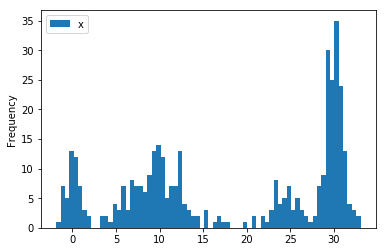

In [252]:
# reading the data
df = pd.read_csv('data.csv')

# TODO: plot the data in order to decide about the parameters of the distribution, use 70 bins
ax = df.plot.hist(bins=70)

## TODO: given the above plot, decide from how many guassian you think the data came from (5 points)

In [253]:
K = get_num_of_gaussians()
K

4

We implemented for you the EM wrraper algorithm.<br>
This function calls to helper functions that you need to implement:<br>
1. init - gussing the initial values of W, Mu, sigma
2. expectation - perform the E-step
3. maximization - perform the M-step
4. calc_max_delta - calculating the maximal delta between each old and new parameters for the stopping condition


## TODO: implement function: `init` (20 points) - OK

implement the init function in a way that makes sense given the data.
notice that as part of the input you can use information about the data and the number of gaussians.

In [254]:
# a simple test for validation using the first dataset composed of 2 gaussians.
# it is recommended to add more tests.
w, mu, sigma = init(xs, 2)
print ("Gaussian weights: %s" % w)
print ("Gaussians mu: %s" % mu)
print ("Gaussians sigma: %s" % sigma)

print ("\nReturn type for w is correct: %s" % (type(w) == np.ndarray))
print ("Return type for mu is correct: %s" % (type(mu) == np.ndarray))
print ("Return type for sigma is correct: %s" % (type(sigma) == np.ndarray))


Gaussian weights: [0.5 0.5]
Gaussians mu: [0.97769087 1.95538173]
Gaussians sigma: [1.63719511 3.27439023]

Return type for w is correct: True
Return type for mu is correct: True
Return type for sigma is correct: True


## TODO: implement function: `expectation` (20 points) - ok

In [256]:
# now we'll test the implementation on a simple dataset

# preparing variables for test
points = [-0.3, 0.3, 0.5]
mu = np.array([-1, 5])
sigma = np.array([1,2])
w = np.array([0.5,0.5])
expected_likelihood_array = np.array([[0.15612697, 0.00297806],
                                      [0.0856843 , 0.00630455],
                                      [0.0647588 , 0.00793491]])

# compute likelihood dataframe
likelihood_array = expectation(points, mu, sigma, w)

# observe the results
print ("Computed array: %sֿ\n" % likelihood_array)
print ("Expected array: %s\n" % expected_likelihood_array)


# validate types
print ("Return type for likelihood_array is correct: %s\n" % (type(likelihood_array) == np.ndarray))

# validate results
print ("Results are correct: %s" % np.allclose(expected_likelihood_array, likelihood_array, atol=0.001))



Computed array: [[0.15612697 0.00297806]
 [0.0856843  0.00630455]
 [0.0647588  0.00793491]]ֿ

Expected array: [[0.15612697 0.00297806]
 [0.0856843  0.00630455]
 [0.0647588  0.00793491]]

Return type for likelihood_array is correct: True

Results are correct: True


## TODO: implement function: `maximization` (20 points) - ok

In [257]:
# we'll now test a simple dataset composed of 4 points, 3 points are from the first gaussian and the 4th is from the second gaussian

points = [-0.9, -1, -1.1, 5]
ranks = np.array([[1,0], [1,0], [1,0], [0,1]])

w_new, mu_new, sigma_new = maximization(points, ranks)

# observe the results
w_new
mu_new
sigma_new

# validate types
print ("Return type for w_new is correct: %s" % (type(w_new) == np.ndarray))
print ("Return type for mu_new is correct: %s" % (type(mu_new) == np.ndarray))
print ("Return type for sigma_new is correct: %s\n" % (type(sigma_new) == np.ndarray))


# validate results
expected_w_new = np.array([0.75, 0.25])
expected_mu_new = np.array([-1.0,  5.0])
expected_sigma_new = np.array([0.08164966, 0.0])
print ("Return value for w_new is correct: %s" % np.allclose(expected_w_new, w_new, atol=0.001))
print ("Return value for  mu_new is correct: %s" % np.allclose(expected_mu_new, mu_new, atol=0.001))
print ("Return value for sigma_new is correct: %s" % np.allclose(expected_sigma_new, sigma_new, atol=0.001))

array([0.75, 0.25])

array([-1.,  5.])

array([0.58499763, 8.66025404])

Return type for w_new is correct: True
Return type for mu_new is correct: True
Return type for sigma_new is correct: True

Return value for w_new is correct: True
Return value for  mu_new is correct: True
Return value for sigma_new is correct: False


## TODO: implement function: `calc_max_delta` (10 points) - OK

Hint: the delta is 0 if the old and new values are equal

Hint: delta is a relative value (without a dimension) 

Return type: float

## TODO: implement function: `ExpectationMaximization` (15 points)

### now, we'll run the EM algorithm on the dataset and 

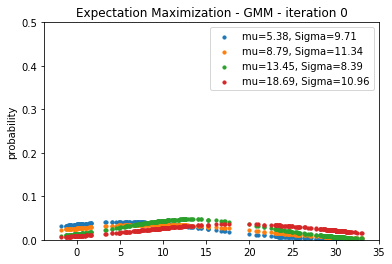

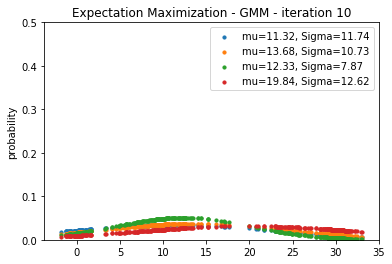

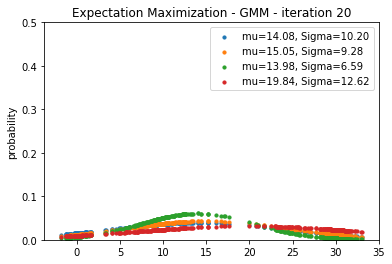

In [ ]:
# run the EM algorithm
res, mu, sigma, log_likelihood = expectation_maximization(df.x.tolist(), K, 1000, 0.0001)

### we can observe that the log likelihood increases between the iterations

Text(0.5, 0, 'iteration')

Text(0, 0.5, 'log likelihood')

Text(0.5, 1.0, 'Log likelihood over iteration')

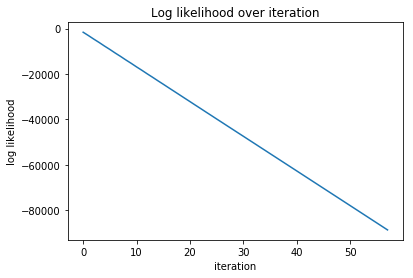

In [194]:
plt.plot(log_likelihood)
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.title('Log likelihood over iteration')
plt.show()

### ploting the output distribution 

In [ ]:
plot_gmm(K, res, mu, sigma, df)